# **Finite difference method for solving local volatility PDE**

To price a European call option with payoff function $(S_T-K)^{+}$ under a local volatility model, we need to solve the PDE

\begin{align}
\frac{\partial V}{\partial t}&=\frac{\sigma^2(t,s) s^2}{2}\frac{\partial^2 V}{\partial s^2} + rs\frac{\partial V}{\partial s} -rV,& t>0 \\
V(0,s)&=(s-K)^{+},& t=0 \\
\sigma(t,s) &= (1 + \frac{T-t}{30})(0.1 + 0.4e^{-\frac{s}{50}})
\end{align}

(Assuming that the time direction has already been reversed such that we work with a PDE with initial condition)



In [ ]:
import numpy as np
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt

# *Setup of the grid and boundary condition*

*Boundary condition*

In this example we will work with the domain of $(t,s)$ directly which is truncated to $D:=[0,T]\times [s_{min},s_{max}]$. Since a call option is involved, we impose the boundary conditions
\begin{align}
V(t,s_{min})=\ell(t,s_{min})=0,\qquad V(t,s_{max})=u(t,s_{max})=s_{max}-Ke^{-rt} \qquad \text{for all } t<T
\end{align}
<br>
<br>
*Grid specification*

We construct a uniform grid over $D$ with $N+1$ points along the time dimension and $M+1$ points along the space dimension. Let
\begin{align*}
\triangle t:=\frac{T}{N},\qquad \triangle x:=\frac{s_{max}-s_{min}}{M}.
\end{align*}
Then the values of the grid points are given by
\begin{align*}
t_n&:=n\triangle t,& n=0,1,...,N \\
s_k&:=s_{min}+k\triangle x,& k=0,1,...,M
\end{align*}

In [ ]:
K, r, T, sigma_c = 100, 0.01, 1, 0.2
s_min, s_max = 0, 300
N, M = 1000, 120
sigma = np.zeros((N+1, M+1))
dt = T/N
dx = (s_max - s_min)/M
s = np.linspace(s_min, s_max, M+1)
t = np.linspace(0, T, N+1)

for i in range(len(t)):
  for j in range(len(s)):
    sigma[i][j] = (1 + (T - t[i])/30)*(0.1 + 0.4 * np.exp(-s[j]/50))

# *Explicit scheme*

Under explicit scheme the PDE can be discretised as

\begin{align*}
\frac{V^{n+1}_k-V^n_{k}}{\triangle t}&=\frac{\sigma^2(T-t_n,s_k) s_k^2}{2}\frac{V^{n}_{k+1}-2V^n_k+V^n_{k-1}}{\triangle x^2}
+rs_k \frac{V^{n}_{k+1}-V^n_{k-1}}{2\triangle x}-r V^n_k \\
\implies \quad V^{n+1}_k&=\left(\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(T-t_n,s_k) s_k^2}{2}-\frac{\triangle t}{2\triangle x}rs_k\right)V^{n}_{k-1}+\left(1-\frac{ \triangle t}{\triangle x^2}\sigma^2(T-t_n,s_k) s_k^2-\triangle t r\right)V^n_k\\
&\qquad +\left(\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(T-t_n,s_k) s_k^2}{2}+\frac{\triangle t}{2\triangle x}rs_k\right)V^{n}_{k+1}\\
&=A^n_k V^n_{k-1} +(1+B^n_k) V^n_{k}+C^n_k V^n_{k+1}
\end{align*}
for $k=1, 2, ..., M-1$, where
\begin{align}
A^n_k:=\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(T-t_n,s_k) s_k^2}{2}-\frac{\triangle t}{2\triangle x}rs_k,\qquad B^n_k:=-\frac{ \triangle t}{\triangle x^2}\sigma^2(T-t_n,s_k) s_k^2-\triangle t r,\qquad C^n_k:=\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(T-t_n,s_k) s_k^2}{2}+\frac{\triangle t}{2\triangle x}rs_k
\end{align}

Recall that the $M-1$ recursive equations can be summarised using matrix notation
\begin{align*}
\underbrace{
\begin{bmatrix}
V^{n+1}_0 \\ 
V^{n+1}_1 \\ 
V^{n+1}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n+1}_{M-1}\\ 
V^{n+1}_M  
\end{bmatrix}}_{=:V^{n+1}}
=
\underbrace{
\begin{bmatrix}
1 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
A^n_1 & 1+B^n_1 & C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & A^n_2 & 1+B^n_2 &C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & A^n_{M-2} &  1+B^n_{M-2}& C^n_{M-2}& 0\\ 
 &  &  &  &  &0 & A^n_{M-1} & 1+B^n_{M-1} & C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &1 
\end{bmatrix}}_{=:\mathbb{I}+L^n}
\underbrace{
\begin{bmatrix}
V^{n}_0 \\ 
V^{n}_1 \\ 
V^{n}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n}_{M-1}\\ 
V^{n}_M  
\end{bmatrix}}_{=:V^{n}}
\end{align*}
Here $\mathbb{I}$ is an $(M+1)\times (M+1)$ identity matrix and $L^n$ is an $(M+1)\times (M+1)$ matrix in form of
\begin{align}
L^n:=
\begin{bmatrix}
0 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
A^n_1 & B^n_1 & C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & A^n_2 & B^n_2 &C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & A^n_{M-2} &  B^n_{M-2}& C^n_{M-2}& 0\\ 
 &  &  &  &  &0 & A^n_{M-1} & B^n_{M-1} & C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &0
\end{bmatrix}
\end{align}


Recall that the system $V^{n+1}=(\mathbb{I}+L^n) V^n$ doesn't give us the correct value of $V^{n+1}_0$ and $V^{n+1}_M$. We need to manually overwrite the first and last entry of the vector to incorporate the boundary conditions at $s=s_0=s_{min}$ and $s=s_M=s_{max}$. The complete recursive algorithm is: 
\begin{align}
V^{n+1}=B^{n+1}((\mathbb{I}+L^n) V^{n})
\end{align}
where $B^{n+1}(\cdot)$ is an operator which overwrites the first and last entry of the input vector to $\ell^{n+1}_0:=\ell(t_{n+1},x_0)$ and $u^{n+1}_{M}:=u(t_{n+1},x_M)$.

Implementation

In [ ]:
# Running the explicit scheme

# Initial condition
v_ex = np.maximum(s - K, 0) # call option payoff


# Iteration of explicit scheme
for n in range(1,N+1):

  # Set up the vectors A, B and C
  A = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
  B = - sigma[n]**2 * dt / dx**2 * s**2 - r * dt
  C = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

  # Setup the matrix L and I
  a_diag = np.concatenate([A[1:-1],[0]])
  b_diag = np.concatenate([[0],B[1:-1],[0]])
  c_diag = np.concatenate([[0],C[1:-1]])
  L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
  I = np.identity(M+1)

  v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
  v_ex[0] = 0                           # Boundary operation at s_min
  v_ex[M] = s_max - K*np.exp(-r*t[n])   # Boundary operation at s_max

Compare against Black-Scholes model.

In [ ]:
# Black-Scholes call option formula
def euro_vanilla_call(S, K, T, r, sigma):
        
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


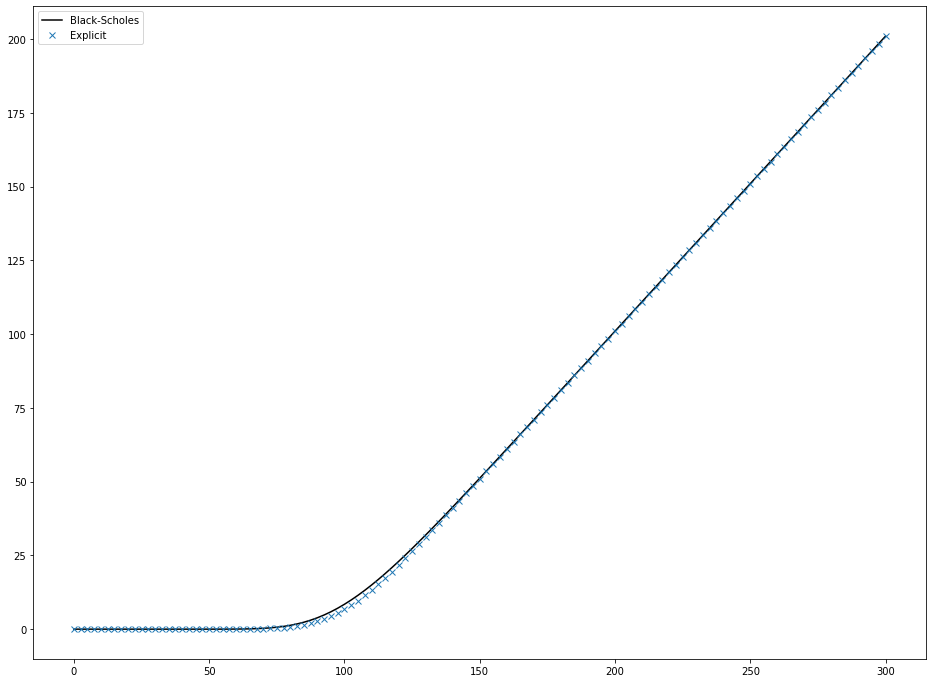

In [ ]:
bscall = euro_vanilla_call(s, K, T, r, sigma_c)

fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, bscall, 'k-', label="Black-Scholes")
ax.plot(s, v_ex, 'x', linewidth=0.5, label="Explicit")
ax.legend()

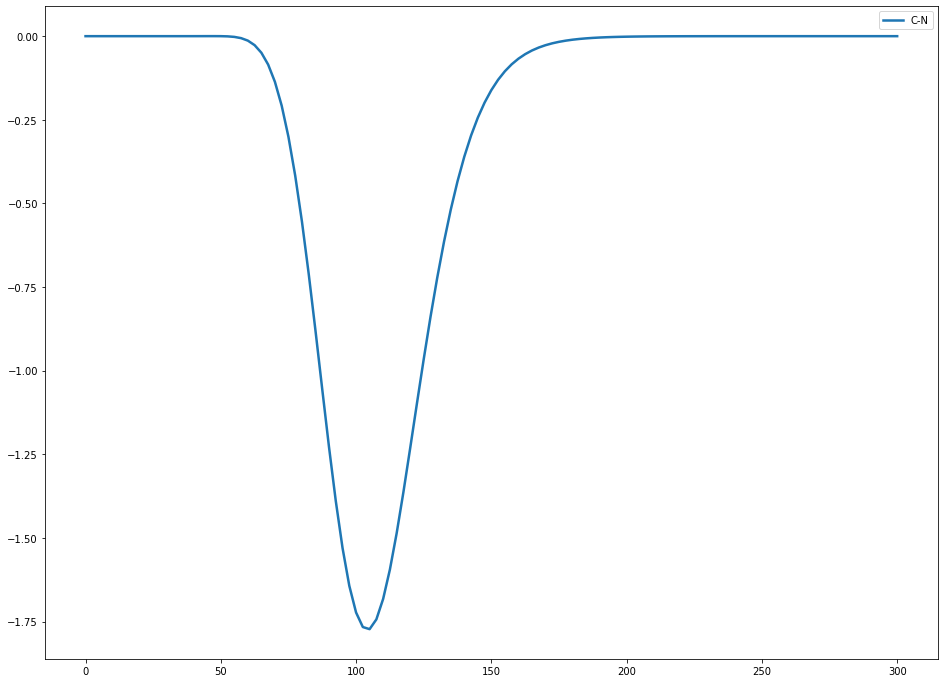

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, v_ex - bscall, linewidth=2.5, label="C-N")
ax.legend()

# *Fully implicit scheme*

Under fully implicit scheme the PDE is now discretised as

\begin{align*}
\frac{V^{n}_k-V^{n-1}_{k}}{\triangle t}&=\frac{\sigma^2(T-t_n,s_k) s_k^2}{2}\frac{V^{n}_{k+1}-2V^n_k+V^n_{k-1}}{\triangle x^2}
+rs_k \frac{V^{n}_{k+1}-V^n_{k-1}}{2\triangle x}-r V^n_k \\
\implies \quad V^{n-1}_k&=-\left(\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(T-t_n,s_k) s_k^2}{2}-\frac{\triangle t}{2\triangle x}rs_k\right)V^{n}_{k-1}+\left(1+\frac{ \triangle t}{\triangle x^2}\sigma^2(T-t_n,s_k) s_k^2+\triangle t r\right)V^n_k\\
&\qquad -\left(\frac{\triangle t}{\triangle x^2}\frac{\sigma^2(T-t_n,s_k) s_k^2}{2}+\frac{\triangle t}{2\triangle x}rs_k\right)V^{n}_{k+1}\\
&=-A^n_k V^n_{k-1} +(1-B^n_k) V^n_{k}-C^n_k V^n_{k+1}
\end{align*}
for $A$, $B$ and $C$ are defined previously. After taking boundary condition into account, a matrix representation is
\begin{align*}
\begin{bmatrix}
1 & 0 & 0 &  \cdots&  &  &  &0 &0\\ 
-A^n_1 & 1-B^n_1 & -C^n_1 & 0 & \cdots &  &  &0 &0\\ 
0 & -A^n_2 & 1-B^n_2 &-C^n_2  & 0 &\cdots  &  && \\ 
 &  &  &  & \ddots & &  &  & \\ 
 \vdots&  &  &  &  & -A^n_k &  1-B^n_k& -C^n_k& 0\\ 
 &  &  &  &  & 0& -A^n_{M-1} & 1-B^n_{M-1} & -C^n_{M-1}\\ 
 0&0  &\cdots  &  & & 0& 0 & 0 &1 
\end{bmatrix}
\begin{bmatrix}
V^{n}_0 \\ 
V^{n}_1 \\ 
V^{n}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n}_{M-1}\\ 
V^{n}_M  
\end{bmatrix}
=
\begin{bmatrix}
\ell^{n}_0 \\ 
V^{n-1}_1 \\ 
V^{n-1}_2 \\ 
 \vdots \\ 
 \vdots\\ 
V^{n-1}_{M-1}\\ 
u^{n}_M  
\end{bmatrix}
\end{align*}
In matrix form, it can be represented as
\begin{align}
(\mathbb{I}-L^{n})V^{n}=B^{n}(V^{n-1}).
\end{align}

To solve $V^{n}$, we implement the Thomas algorithm which solves system of equation $Ax=d$ with $A$ being a tridiagonal matrix of the form
\begin{align*}
\begin{bmatrix}
b_0 & c_0 & 0 &  \cdots&  &  &  &0 &0 \\ 
a_1 & b_1 & c_1 & 0 & \cdots &  &  &0 &0 \\ 
0 & a_2 & b_2 &c_2  & 0 &\cdots  &  & &  \\ 
 &  &  &  & \ddots & &  &  &   \vdots\\ 
 \vdots&  &  &  &  & a_{M-2} & b_{M-2}& c_{M-2}& 0 \\ 
 &  &  &  &  & 0& a_{M-1} & b_{M-1} & c_{M-1} \\ 
 0&0  &\cdots  &  & & 0& 0 & a_M &b_M 
\end{bmatrix}
\end{align*}

In [ ]:
# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

Now we run the iteration to solve the resursion
\begin{align}
(\mathbb{I}-L^{n})V^{n}=B^{n}(V^{n-1}).
\end{align}

In [ ]:
# Running the implicit scheme

# Initial condition
v_im = np.maximum(s - K, 0)

# Iteration of implicit scheme
for n in range(1,N+1):

  # Set up the vectors A, B and C
  A = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
  B = - sigma[n]**2 * dt / dx**2 * s**2 - r * dt
  C = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

  # Setup the matrix L and I
  a_diag = np.concatenate([A[1:-1],[0]])
  b_diag = np.concatenate([[0],B[1:-1],[0]])
  c_diag = np.concatenate([[0],C[1:-1]])

  d = v_im   # The RHS of the system of equations is V^{n-1}
  d[0] = 0   # Boundary operator at s_min
  d[M] = s_max - K*np.exp(-r*t[n])  # Boundary operator at s_max
  v_im = TDMAsolver(-a_diag, 1-b_diag, -c_diag, d)   # Run the Thomas algorithm to solve for V^n

Compare against Black-Scholes model.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


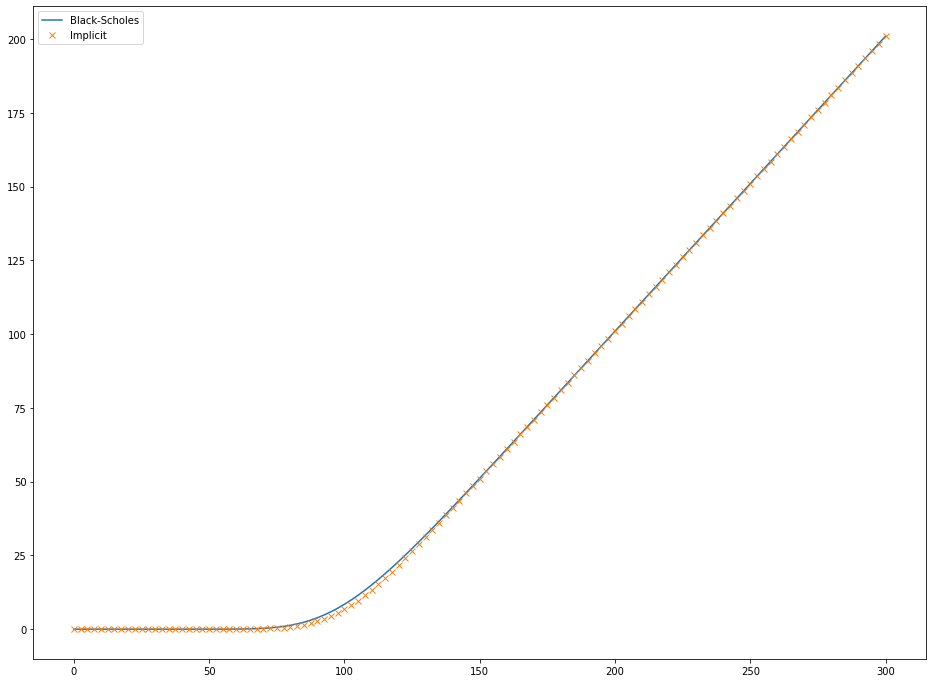

In [ ]:
bscall = euro_vanilla_call(s, K, T, r, sigma_c)

fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, bscall, label="Black-Scholes")
ax.plot(s, v_im, 'x', linewidth=2.5, label="Implicit")
#ax.plot(s, v_ex, linewidth=2.5, label="Implicit")
ax.legend()

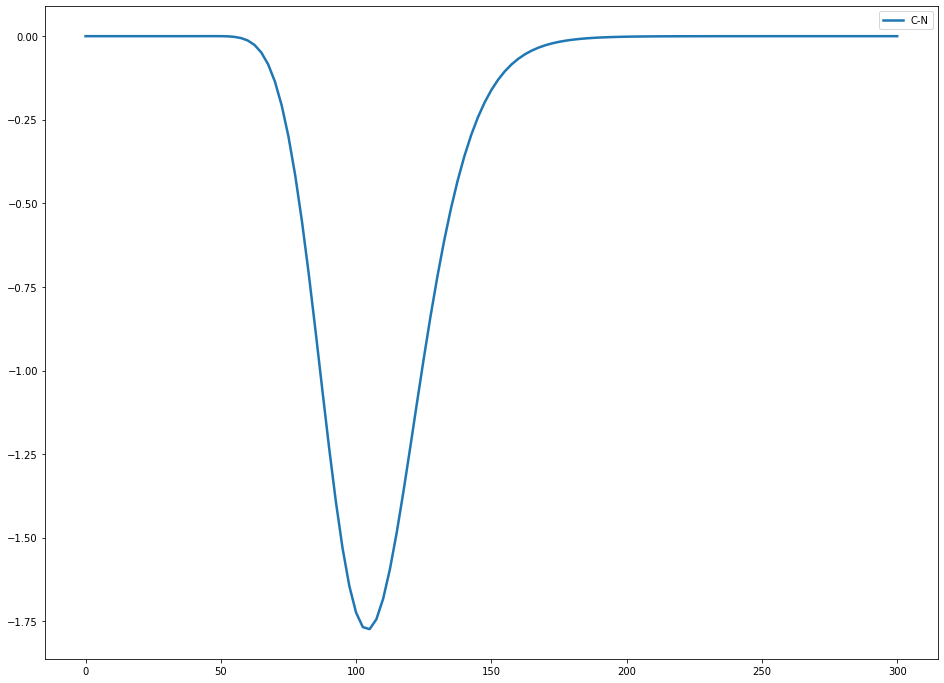

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, v_im - bscall, linewidth=2.5, label="C-N")
ax.legend()

# *Crank-Nicolson scheme*

In [ ]:
# Running the C-N scheme
theta = 0.5

# Initial condition
v_cn = np.maximum(s - K, 0)

A = 0.5 * sigma[0]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
B = - sigma[0]**2 * dt / dx**2 * s**2 - r * dt
C = 0.5 * sigma[0]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

a_diag = np.concatenate([A[1:-1],[0]])
b_diag = np.concatenate([[0],B[1:-1],[0]])
c_diag = np.concatenate([[0],C[1:-1]])
L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
I = np.identity(M+1)

# Iteration of C-N scheme
for n in range(1,N+1):

  d = np.matmul((I + (1 - theta) * L), v_cn)   
  d[0] = 0   
  d[M] = s_max - K*np.exp(-r*t[n])  
  v_cn = TDMAsolver(-theta*a_diag, 1-theta*b_diag, -theta*c_diag, d)

  A = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
  B = - sigma[n]**2 * dt / dx**2 * s**2 - r * dt
  C = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

  a_diag = np.concatenate([A[1:-1],[0]])
  b_diag = np.concatenate([[0],B[1:-1],[0]])
  c_diag = np.concatenate([[0],C[1:-1]])
  L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()

Compare against Black-Scholes model.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


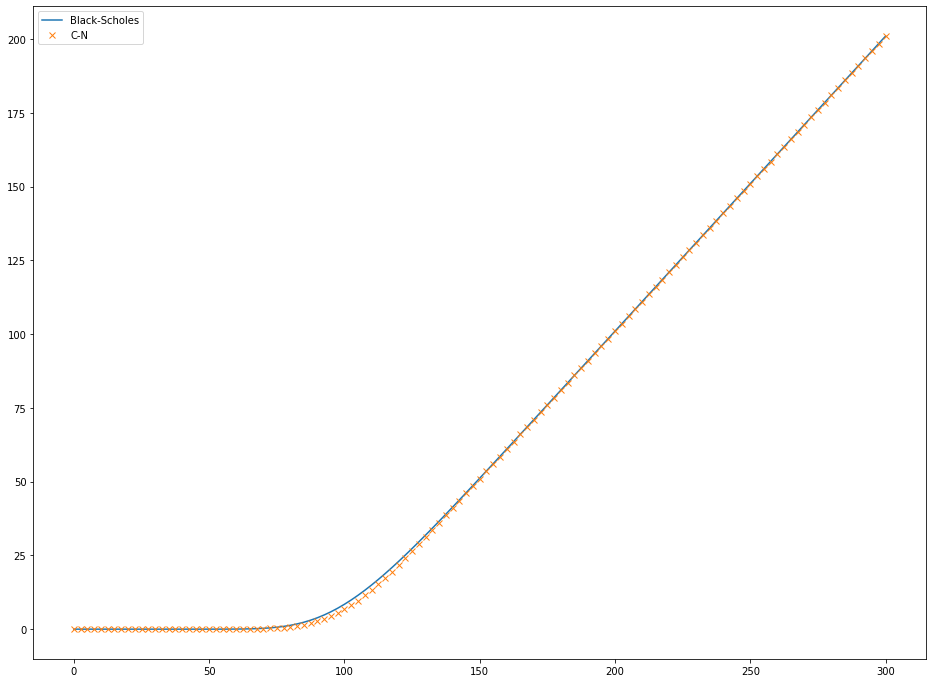

In [ ]:
bscall = euro_vanilla_call(s, K, T, r, sigma_c)

fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, bscall, label="Black-Scholes")
ax.plot(s, v_cn, 'x', linewidth=2.5, label="C-N")
ax.legend()

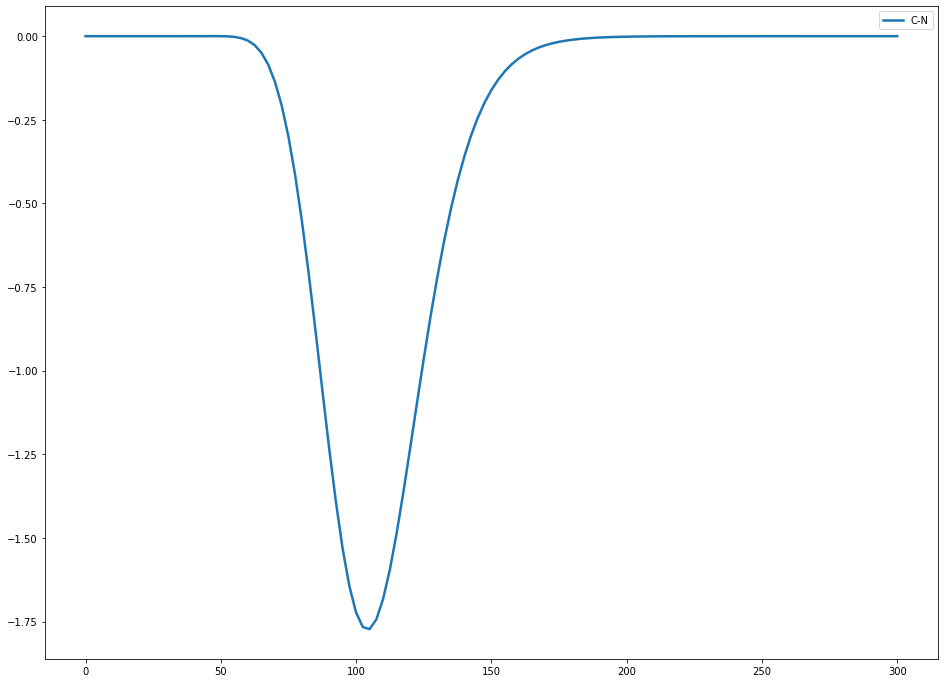

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, v_cn - bscall, linewidth=2.5, label="C-N")
ax.legend()

Report the prices of European call option under the local volatility model against a range of stock price $S_0 \in \{80,85,...,120\}$

[ 0.74758984  1.46729566  2.63304292  4.35797829  6.71076631  9.69758534
 13.26270604 17.30629558 21.71055361]
[ 0.74819288  1.46736545  2.63237601  4.35666169  6.70916846  9.69617608
 13.26182973 17.30604478 21.71079607]
[ 0.74798027  1.46746048  2.6328784   4.35751618  6.71017166  9.69707225
 13.26243047 17.30629582 21.71076374]


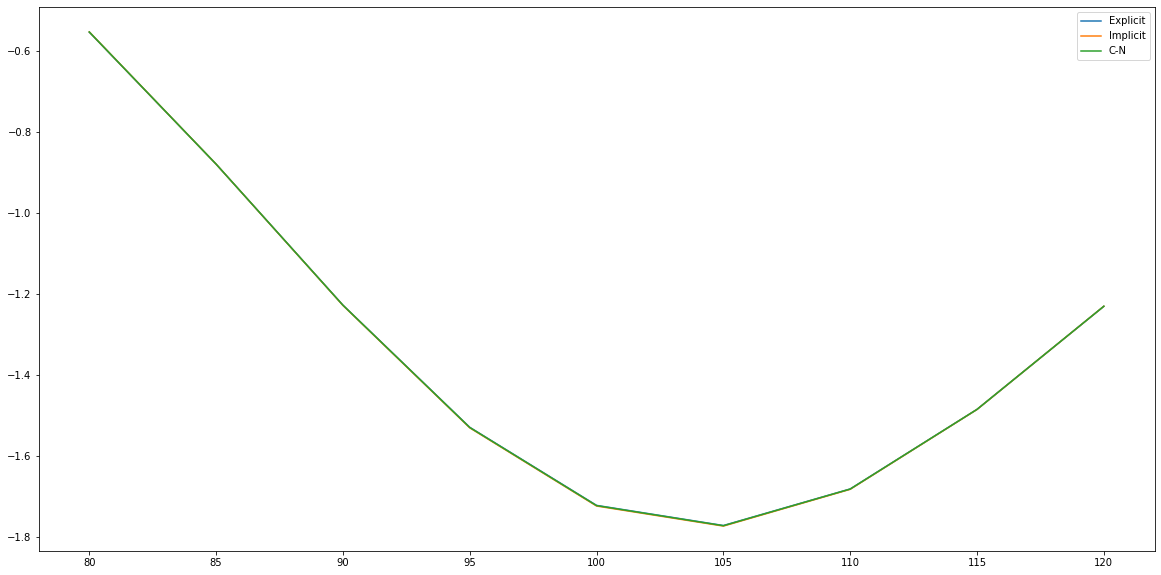

In [ ]:
s_0 = np.arange(80, 121 ,5)
V_ex = np.zeros(len(s_0))
V_im = np.zeros(len(s_0))
V_cn = np.zeros(len(s_0))
k = int((s_0[0] - s_min)/ dx)

bscall_s0 = euro_vanilla_call(s_0, K, T, r, sigma_c)

for i in range(len(s_0)):
  V_ex[i] = v_ex[k + 2*i]
  V_im[i] = v_im[k + 2*i]
  V_cn[i] = v_cn[k + 2*i]
print(V_ex) 
print(V_im)
print(V_cn)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(s_0, V_ex - bscall_s0, label="Explicit")
ax.plot(s_0, V_im - bscall_s0, label="Implicit")
ax.plot(s_0, V_cn - bscall_s0, label="C-N")
ax.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


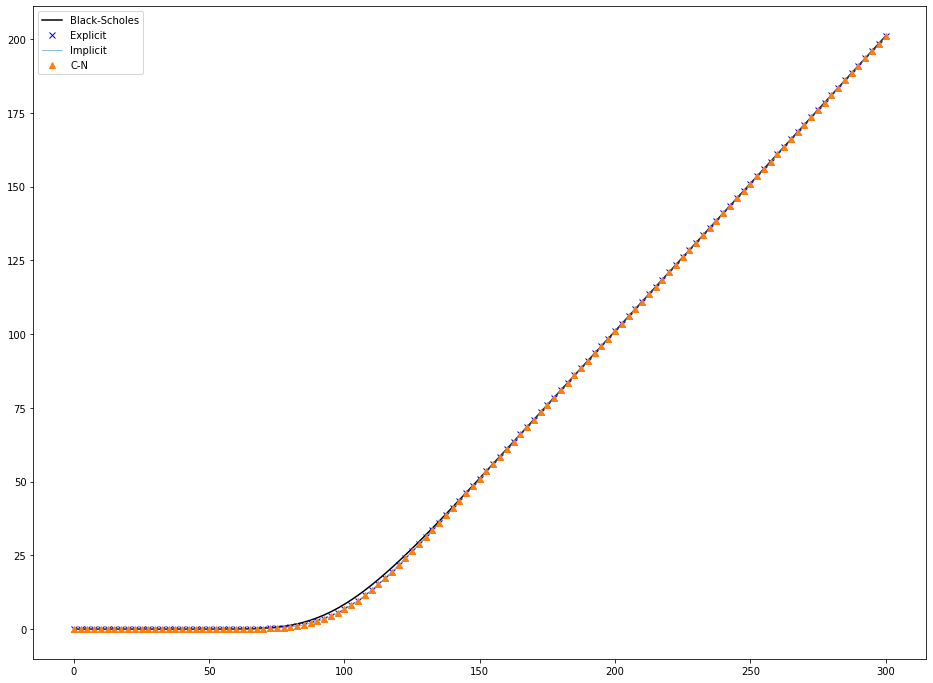

In [ ]:
bscall = euro_vanilla_call(s, K, T, r, sigma_c)

fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, bscall, 'k-', label="Black-Scholes")
ax.plot(s, v_ex, 'x', color = "blue", linewidth=0.5, label="Explicit")
ax.plot(s, v_im, '-', linewidth=0.5, label="Implicit")
ax.plot(s, v_cn, '^', linewidth=0.5, label="C-N")
ax.legend()

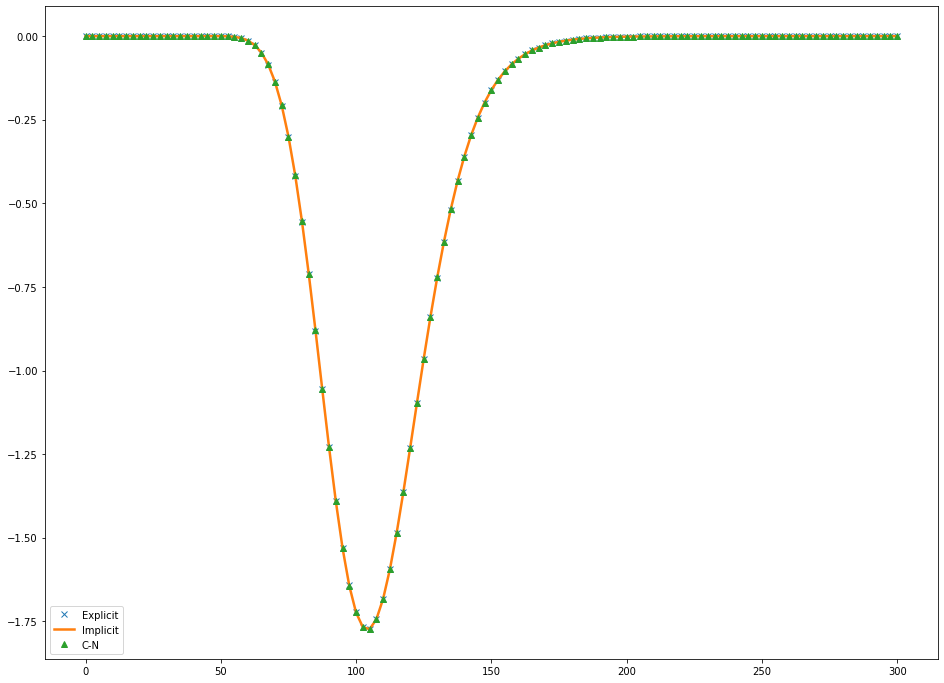

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(s, v_ex - bscall, 'x', linewidth=2.5, label="Explicit")
ax.plot(s, v_im - bscall, '-', linewidth=2.5, label="Implicit")
ax.plot(s, v_cn - bscall, '^', linewidth=2.5, label="C-N")
ax.legend()